In [1]:
import os
import datetime
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize,LinearSegmentedColormap

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
# removing duplicate images from same lesion

df=pd.read_csv('dataverse_files/HAM10000_metadata.csv')
# if your image names have no extension
df['image_id'] = df['image_id'].astype(str) + '.jpg'

df=df.drop(['image_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
labels = df['dx'].unique() # 7 labels
labels = list(labels)
labels.sort()
print(labels)
df.drop_duplicates( subset=['lesion_id'], keep=False, inplace=True)
# how many images are there for each labels
lesion_counts = []
df_lesion = df['dx'].sort_values()
for label in labels:
    lesion_counts += [len(df[df['dx'] == label])]
    #print("There are " + str(len(df[df['dx'] == label])) + " images belong to " + label + " label")
print(lesion_counts)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
[151, 175, 440, 39, 230, 4415, 64]


In [3]:
# Same for test set

df_test=pd.read_csv('dataverse_files/ISIC2018_Task3_Test_GroundTruth.csv')
# if your image names have no extension
df_test['image_id'] = df_test['image_id'].astype(str) + '.jpg'

df_test=df_test.drop(['image_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
labels_test = df_test['dx'].unique() # 7 labels_test
labels_test = list(labels_test)
labels_test.sort()
print(labels_test)
df_test.drop_duplicates( subset=['lesion_id'], keep=False, inplace=True)
# how many images are there for each labels_test
lesion_counts_test = []
df_test_lesion = df_test['dx'].sort_values()
for label in labels_test:
    lesion_counts_test += [len(df_test[df_test['dx'] == label])]
    #print("There are " + str(len(df_test[df_test['dx'] == label])) + " images belong to " + label + " label")
print(lesion_counts_test)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
[21, 56, 132, 37, 60, 665, 26]


In [4]:
df=pd.read_csv('dataverse_files/HAM10000_metadata.csv')
# if your image names have no extension
df['image_id'] = df['image_id'].astype(str) + '.jpg'

df=df.drop(['lesion_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
labels = df['dx'].unique() # 7 labels
labels = list(labels)
labels.sort()
print(labels)
# how many images are there for each labels
image_counts = []
df_image = df['dx'].sort_values()
for label in labels:
    image_counts += [len(df[df['dx'] == label])]
    #print("There are " + str(len(df[df['dx'] == label])) + " images belong to " + label + " label")
print(image_counts)


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
[327, 514, 1099, 115, 1113, 6705, 142]


In [5]:
# Same for test 
df_test=pd.read_csv('dataverse_files/ISIC2018_Task3_Test_GroundTruth.csv')
# if your image names have no extension
df_test['image_id'] = df_test['image_id'].astype(str) + '.jpg'

df_test=df_test.drop(['lesion_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
labels_test = df_test['dx'].unique() # 7 labels_test
labels_test = list(labels_test)
labels_test.sort()
print(labels_test)
# how many images are there for each labels_test
image_counts_test = []
df_test_image = df_test['dx'].sort_values()
for label in labels_test:
    image_counts_test += [len(df_test[df_test['dx'] == label])]
    #print("There are " + str(len(df_test[df_test['dx'] == label])) + " images belong to " + label + " label")
print(image_counts_test)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
[43, 93, 217, 44, 171, 909, 35]


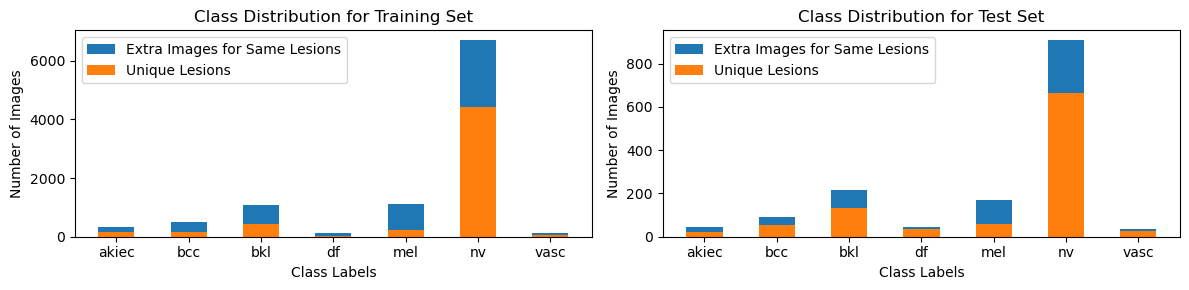

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
bins = np.linspace(0 - .25, 6 + .25, 14)

# Plotting class distribution for training set

ax1.hist(df_image.values, bins=bins)
ax1.hist(df_lesion.values, bins=bins)
ax1.set_title("Class Distribution for Training Set")
ax1.set_xlabel('Class Labels')
ax1.set_ylabel('Number of Images')
ax1.legend(['Extra Images for Same Lesions', 'Unique Lesions'])

# Plotting class distribution  for test set
ax2.hist(df_test_image.values, bins=bins)
ax2.hist(df_test_lesion.values, bins=bins)
ax2.set_title("Class Distribution for Test Set")
ax2.set_xlabel('Class Labels')
ax2.set_ylabel('Number of Images')
ax2.legend(['Extra Images for Same Lesions', 'Unique Lesions'])

plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()


In [7]:
'''
random.seed(42)
np.random.seed(42)
np.random.RandomState(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
'''

"\nrandom.seed(42)\nnp.random.seed(42)\nnp.random.RandomState(42)\ntf.random.set_seed(42)\nos.environ['TF_DETERMINISTIC_OPS'] = '1'\n"

In [8]:
'''
grouped = df.groupby('dx')
for label in labels:
    drop_indices = []
    remove_n = grouped.get_group(label).shape[0] - 115 # number of images in the smallest class
    drop_indices = np.random.choice(grouped.get_group(label).index, remove_n, replace=False)
    df = df.drop(drop_indices) # drop extra images from original dataset
    '''

"\ngrouped = df.groupby('dx')\nfor label in labels:\n    drop_indices = []\n    remove_n = grouped.get_group(label).shape[0] - 115 # number of images in the smallest class\n    drop_indices = np.random.choice(grouped.get_group(label).index, remove_n, replace=False)\n    df = df.drop(drop_indices) # drop extra images from original dataset\n    "

In [31]:
# 'ISIC_0035068.jpg' is missing in the dataset, lets remove it from test set
df_test = df_test[df_test['image_id'] != 'ISIC_0035068.jpg']

print(labels,'\n')

df.sort_values(by=['image_id'], inplace=True)
df.reset_index(inplace=True, drop=True)
df_test.sort_values(by=['image_id'], inplace=True)
df_test.reset_index(inplace=True, drop=True)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 



In [32]:
train_df, val_df=train_test_split(df, train_size=0.9, shuffle=True, random_state=123, stratify=df['dx']) 
test_df = df_test.copy().sample(frac=1, random_state=123).reset_index(drop=True) # shuffle test set
for label in labels:
    list1 = len(train_df[train_df['dx'] == label]), len(val_df[val_df['dx'] == label]), len(test_df[test_df['dx'] == label])
    space = ' '
    print(label,(5-len(label))*space ,list1)
    
train_df.shape, val_df.shape, test_df.shape

akiec  (294, 33, 43)
bcc    (463, 51, 93)
bkl    (989, 110, 217)
df     (103, 12, 44)
mel    (1002, 111, 171)
nv     (6034, 671, 908)
vasc   (128, 14, 35)


((9013, 2), (1002, 2), (1511, 2))

In [11]:
# Save splitted dataframes to csv
train_df.to_csv('dataverse_files/train_split.csv', index=False)
val_df.to_csv('dataverse_files/val_split.csv', index=False)
test_df.to_csv('dataverse_files/test_split.csv', index=False)

# Read splitted dataframes from csv
train_df=pd.read_csv('dataverse_files/train_split.csv')
val_df=pd.read_csv('dataverse_files/val_split.csv')
test_df=pd.read_csv('dataverse_files/test_split.csv')

In [15]:
rescale=1./255
color_mode = 'rgb'
target_size = (48, 48, 3)
batch_size  = 32
# 600 x 450

train_datagen = ImageDataGenerator(rescale=rescale)
train_set = train_datagen.flow_from_dataframe(train_df,
                                              directory="dataverse_files/HAM10000_images",
                                              x_col="image_id",
                                              y_col="dx",
                                              color_mode=color_mode,
                                              target_size=target_size,
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              )
val_datagen = ImageDataGenerator(rescale=rescale)
val_set = val_datagen.flow_from_dataframe(val_df,
                                          directory="dataverse_files/HAM10000_images",
                                          x_col="image_id",
                                          y_col="dx",
                                          color_mode=color_mode,
                                          target_size=target_size,
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          )
test_datagen = ImageDataGenerator(rescale=rescale)
test_set = test_datagen.flow_from_dataframe(test_df,
                                            directory="dataverse_files/ISIC2018_Task3_Test_Images",
                                            x_col="image_id",
                                            y_col="dx",
                                            color_mode=color_mode,
                                            target_size=target_size,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            )

Found 9013 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.
Found 1511 validated image filenames belonging to 7 classes.


/Users/mehmet/anaconda3/envs/cs464/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


In [11]:
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64, kernel_size=(3,3), input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


#2nd CNN layer
model.add(Conv2D(32,(5,5),padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

#1st Fully Connected layer
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

#2nd Fully Connected layer
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))

#Last Layer
model.add(Dense(no_of_classes))
model.add(Activation('softmax'))


#model.add(Dropout(0.25))

model.compile(optimizer=Adam(learning_rate = 0.001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 32)        51232     
                                                                 
 activation_1 (Activation)   (None, 23, 23, 32)        0

In [15]:
now = datetime.datetime.now().strftime("%d-%m-%H-%M")
os.mkdir(now)
# save last model variable to txt file
checkpoint = ModelCheckpoint(f"/Users/mehmet/Documents/vs-code/CS464-Introduction-to-Machine-Learning/Project/{now}/model-{now}.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit            (train_set,
                                #steps_per_epoch=50,
                                epochs=15,
                                validation_data = val_set,
                                #validation_steps = 15,
                                )

Epoch 1/15


2023-11-04 22:13:10.941600: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


251/251 [==============================] - 37s 147ms/step - loss: 1.0352 - accuracy: 0.6690 - val_loss: 1.3533 - val_accuracy: 0.6683
Epoch 2/15
251/251 [==============================] - 37s 145ms/step - loss: 0.9202 - accuracy: 0.6929 - val_loss: 1.0708 - val_accuracy: 0.6935
Epoch 3/15
251/251 [==============================] - 37s 146ms/step - loss: 0.8515 - accuracy: 0.7085 - val_loss: 1.1668 - val_accuracy: 0.6804
Epoch 4/15
251/251 [==============================] - 37s 146ms/step - loss: 0.8029 - accuracy: 0.7230 - val_loss: 1.0523 - val_accuracy: 0.6633
Epoch 5/15
251/251 [==============================] - 37s 148ms/step - loss: 0.7574 - accuracy: 0.7434 - val_loss: 1.0185 - val_accuracy: 0.6754
Epoch 6/15
251/251 [==============================] - 37s 149ms/step - loss: 0.6950 - accuracy: 0.7622 - val_loss: 0.9798 - val_accuracy: 0.6734
Epoch 7/15
251/251 [==============================] - 38s 151ms/step - loss: 0.6373 - accuracy: 0.7806 - val_loss: 1.0105 - val_accuracy: 0.6

In [51]:
with open('last.txt', 'w') as f:
    f.write(str(now))

model.save(f"/Users/mehmet/Documents/vs-code/CS464-Introduction-to-Machine-Learning/Project/{now}/model-{now}.h5")

# convert the history.history dict to a pandas DataFrame:
if type(history) is not pd.DataFrame:
    history = pd.DataFrame(history.history) 

# save to csv: 
hist_csv_file = f'{now}/history-{now}.csv'
with open(hist_csv_file, mode='w') as f:
    history.to_csv(f)

In [12]:
# read last model variable from txt file
now = open('last.txt', 'r').read()
model = load_model(f"/Users/mehmet/Documents/vs-code/CS464-Introduction-to-Machine-Learning/Project/{now}/model-{now}.h5")
history = pd.read_csv(f'{now}/history-{now}.csv')

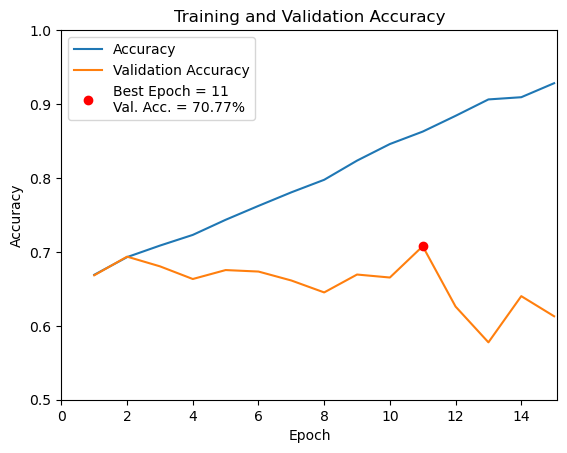

In [13]:
epochs = range(1, history.shape[0]+1)
plt.plot(epochs, history['accuracy'], label='Accuracy')
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
max_val_acc_epoch = np.argmax(history['val_accuracy']) + 1
max_val_acc = history['val_accuracy'][max_val_acc_epoch-1]
label='Best Epoch = '+str(max_val_acc_epoch)+'\nVal. Acc. = '+str((max_val_acc*100).round(2))+ '%'
plt.plot(max_val_acc_epoch, max_val_acc, 'ro', label=label)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim([0, history.shape[0]+0.1])
plt.ylim([0.5, 1])
plt.title('Training and Validation Accuracy')
plt.legend(loc='upper left')

plt.savefig(f'{now}/val-acc-{now}.png')

In [212]:
print(test_set.class_indices)
print(test_set.classes[:5])
print(test_set.filenames[:5])
print('\n PREDICTING LABELS OF TEST IMAGES')
result = model.predict(test_set)
y_pred = np.argmax(result, axis=1)
print(y_pred)
#save y_pred to csv file
np.savetxt(f'{now}/pred-{now}.csv', y_pred, delimiter=',', fmt='%d')

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
[2, 4, 5, 5, 5]
['ISIC_0028681.jpg', 'ISIC_0025450.jpg', 'ISIC_0026162.jpg', 'ISIC_0026985.jpg', 'ISIC_0033420.jpg']

 PREDICTING LABELS OF TEST IMAGES
32/32 [==============================] - 4s 124ms/step
[4 2 5 ... 2 5 3]


In [14]:
# read y_pred from csv file
y_pred = np.loadtxt(f'{now}/pred-{now}.csv', delimiter=',', dtype=int)
y_pred

array([4, 2, 5, ..., 2, 5, 3])

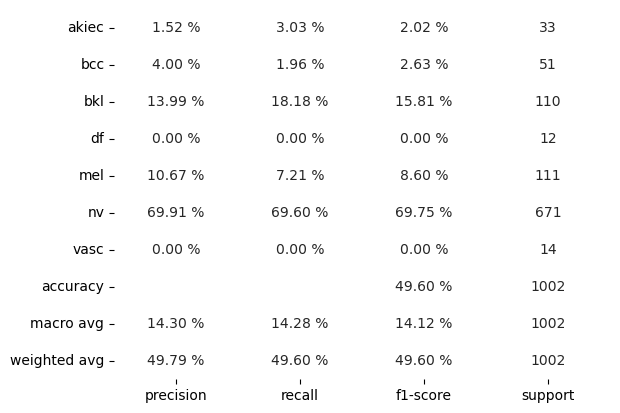

In [18]:
y_true = test_set.classes # List containing true labels for each image.

# Understanding classification power of model on each class    
report = classification_report(y_true, y_pred, target_names=test_set.class_indices.keys())
report_d = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True, target_names=test_set.class_indices.keys())).transpose()
report_d['support']['accuracy'] = report_d['support']['macro avg']


annot = report_d.copy()
annot.iloc[:, 0:3] = (annot.iloc[:, 0:3]*100).applymap('{:.2f}'.format) + ' %'
annot.iloc[7, 1] = ''
annot.iloc[7, 0] = ''
annot['support'] = annot['support'].astype(int)

# how to save report as image
norm = Normalize(-1,1)
cmap = LinearSegmentedColormap.from_list("", [[norm(-1.0), "white"],[norm( 1.0), "white"]])
plot = sns.heatmap(report_d, annot=annot, cmap=cmap, cbar=False, fmt='')
fig = plot.get_figure()
fig.savefig(f'{now}/report-{now}.png')

F1-score of model prediction is: 49.60 %


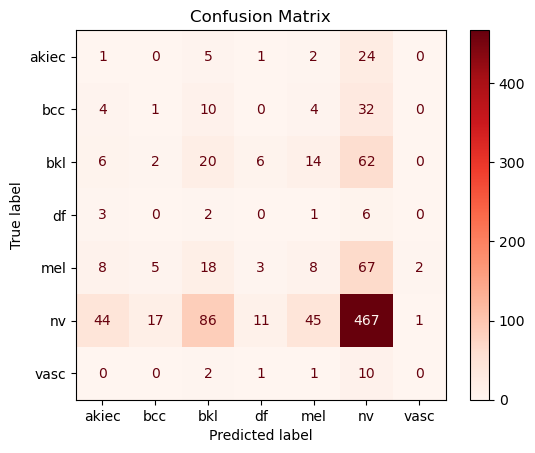

In [26]:
f1_score = ((report_d['f1-score']['weighted avg']*100000//10)/100)
print('F1-score of model prediction is: {:.2f} %'.format(f1_score))

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=test_set.class_indices.keys()
                              )
disp.plot(cmap='Reds')
disp.ax_.set_title('Confusion Matrix')
disp.figure_.savefig(f'{now}/confusion-matrix-{now}.png')